# Recommender system using NMF

## Setup

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split            
from sklearn.metrics import accuracy_score, confusion_matrix
import re

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
plt.style.use('ggplot')
sns.set_style('dark')
sns.set_palette('muted', color_codes=True)  
random_seed = 0
np.random.seed(random_seed)

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = '.kaggle\kaggle.json'
!kaggle datasets download -d odedgolden/movielens-1m-dataset -p data\movielens
with zipfile.ZipFile('data/movielens/movielens-1m-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data/movielens')

movielens-1m-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
movies = pd.read_csv('data/movielens/movies.dat', sep='::', header=None,
                     names=['movie_id', 'title', 'genres'], encoding='latin-1', engine='python')          
ratings = pd.read_csv('data/movielens/ratings.dat', sep='::', header=None,
                      names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin-1', engine='python')
users = pd.read_csv('data/movielens/users.dat', sep='::', header=None,
                     names=['user_id', 'sex', 'age', 'occupation', 'zipcode'], encoding='latin-1', engine='python') 

## EDA

We have three dataframes: movies, users and ratings. 

### Movies

The movies dataframe contains the movieId, title and genres of 3883 movies

In [6]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Let's create a new column called year which contains the year of the movie release. Also we are going to clean the genres column by removing the pipe character and splitting the genres into a list. 

In [7]:
movies['year'] = movies['title'].str.extract(r'.*\((.*)\).*', expand=True)
movies['year'] = pd.to_datetime(movies['year'], format='%Y')
movies['year'] = movies['year'].dt.year
movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))', '', regex=True)  
movies['genres'] = movies['genres'].str.split('|') 
movies              


,movie_id,title,genres,year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
3878,3948,Meet the Parents,[Comedy],2000
3879,3949,Requiem for a Dream,[Drama],2000
3880,3950,Tigerland,[Drama],2000
3881,3951,Two Family House,[Drama],2000


Let's explore the number of movies released per year.

Text(0.5, 0, 'Year')

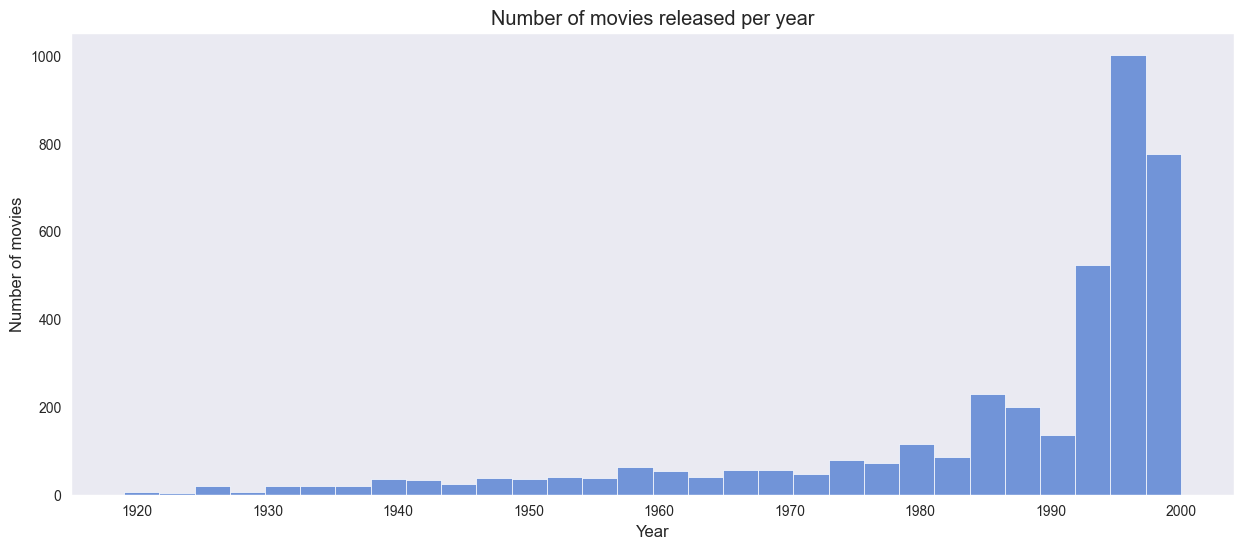

In [8]:
plt.figure(figsize=(15, 6))     
sns.histplot(movies['year'], bins=30, kde=False)                
plt.title('Number of movies released per year')             
plt.ylabel('Number of movies')
plt.xlabel('Year')  
    

The majority of the movies were released between 1990 and 2000.
Now let's explore the genres.

In [9]:
unique_genres = set()   
for movie_genres in movies['genres'].values:
    unique_genres.update(movie_genres)      
tmp = movies['genres'].str.join('|').str.get_dummies() 
movie_genres = pd.concat([movies[['movie_id', 'year']], tmp], axis=1)
movie_genres

,movie_id,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,2000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,3950,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,3951,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


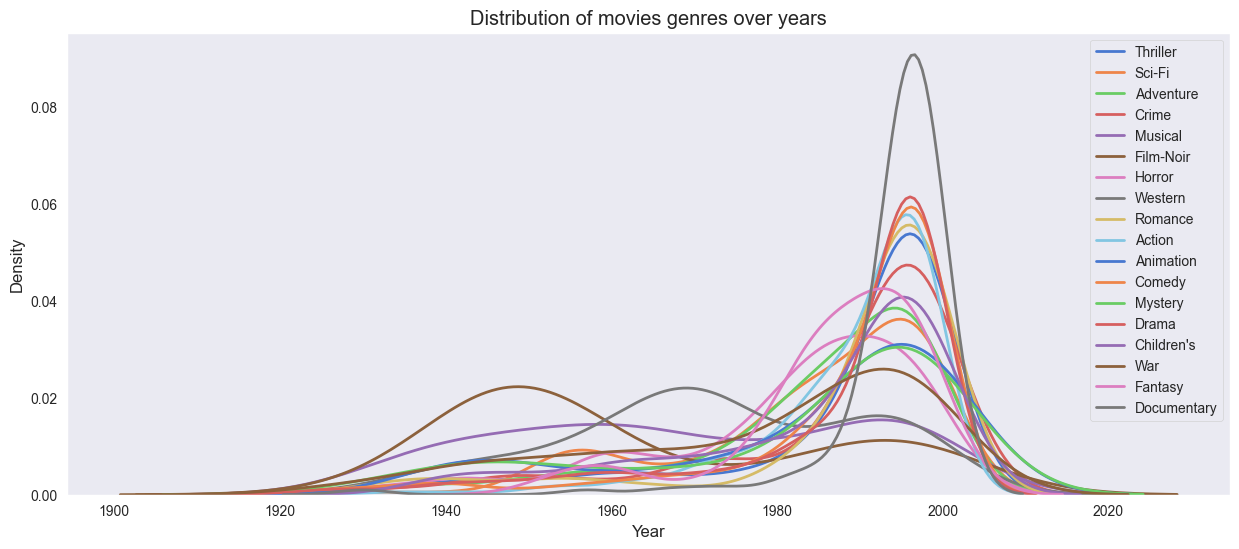

In [10]:
plt.figure(figsize=(15, 6))
for genre in unique_genres:
    tmp = movie_genres[movie_genres[genre] == 1]
    sns.kdeplot(tmp['year'], label=genre, linewidth=2)
plt.title('Distribution of movies genres over years')       
plt.ylabel('Density')
plt.xlabel('Year')  
plt.legend()  

There is a significant number of documentaries released around 1990. Some interesting findings are the number of sci-fi movies released around 1980 and the decline of children movies around 1960.

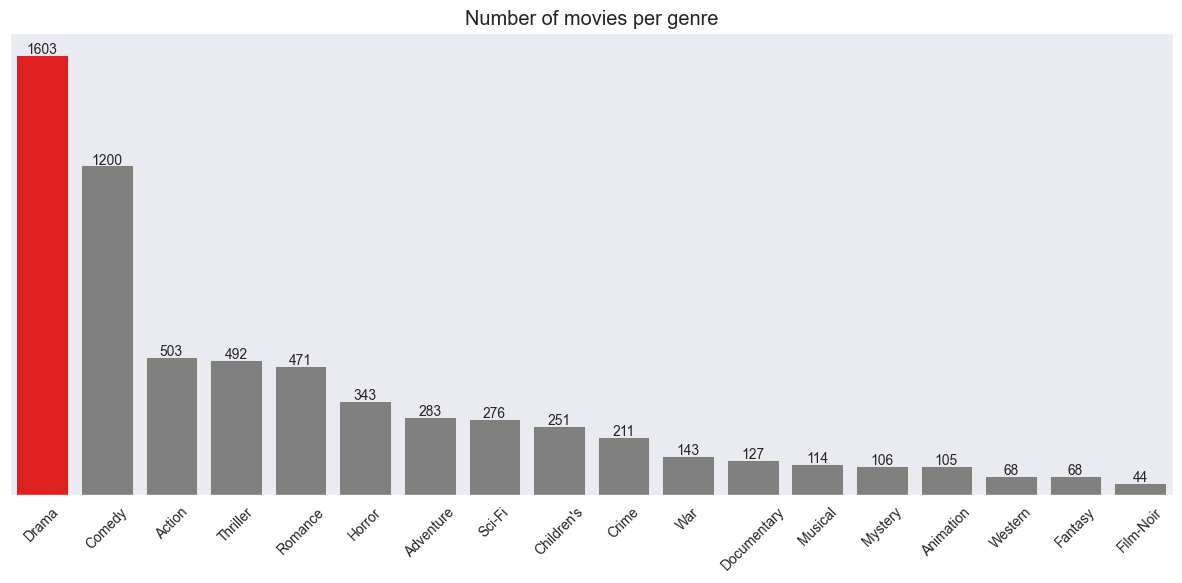

In [11]:
unique_genres = list(unique_genres)
tmp = movie_genres[unique_genres].sum(axis=0).sort_values(ascending=False)
colors = ['gray' if (x < max(tmp.values)) else 'red' for x in tmp.values]
plt.figure(figsize=(15, 6))
fig = sns.barplot(x=tmp.index, y=tmp.values, palette=colors)
plt.title('Number of movies per genre')
patches = fig.patches
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+5,s='{:.0f}'.format(height), ha='center')
plt.tick_params(labelbottom=True, labelleft=False)
plt.xticks(rotation=45);



Most movies are classified as drama, comedy and action.

### Users

The users dataframe contains the user_id, sex, age and zipcode of 6040 users.

In [12]:
users

,user_id,sex,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


Let's explore the age distribution of the users.

<Axes: xlabel='age', ylabel='Count'>

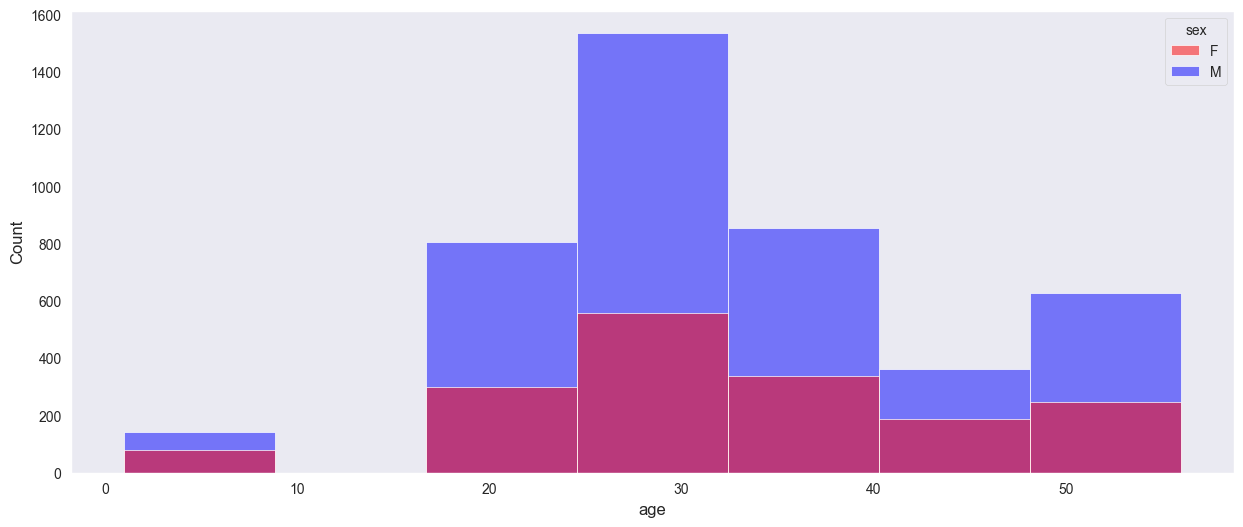

In [13]:
plt.figure(figsize=(15, 6))
sns.histplot(data=users, x='age', bins=7, kde=False, hue='sex', palette=['red','blue'])

Most users are between 18 and 50 years old. Also there is a significant amount of users who identified as male.

### Ratings

The ratings dataframe contains the user_id, movie_id, rating and timestamp of 1000209 ratings.

In [14]:
tmp = pd.merge(ratings, movie_genres, on='movie_id', how='left')
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


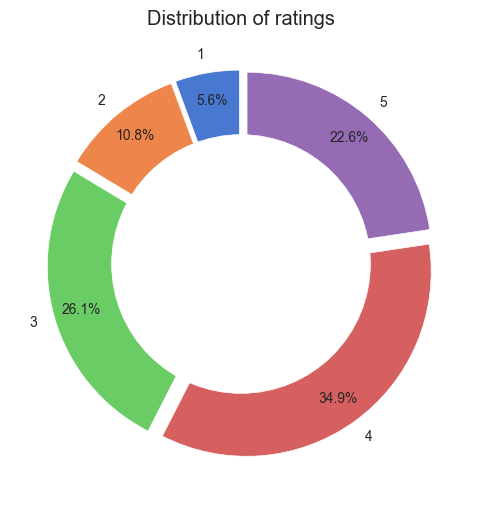

In [15]:

plt.figure(figsize=(15, 6))
data = tmp['rating'].value_counts().sort_index()    
plt.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=[0.05]*5)
plt.title('Distribution of ratings')
circle = plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)

 


Most of the ratings can be considered positive, that could be because people tend to rate movies they like.
Let's explore the average rating per movie genre.

(0.0, 5.0)

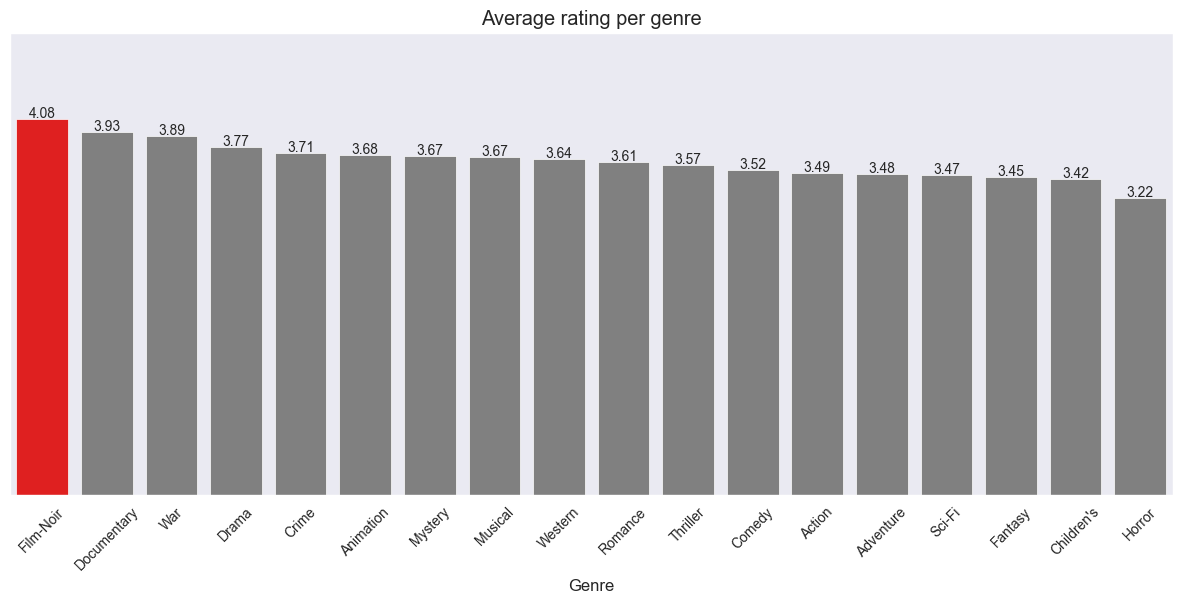

In [16]:
avg_ratings_by_genre = pd.DataFrame(columns=['genre', 'avg_rating'])    
for genre in unique_genres:
    tmp_= tmp[tmp[genre] == 1]
    # print(tmp_)
    avg_ratings_by_genre = pd.concat([avg_ratings_by_genre, pd.DataFrame([[genre, tmp_['rating'].mean()]], columns=['genre', 'avg_rating'])])
avg_ratings_by_genre = avg_ratings_by_genre.sort_values(by='avg_rating', ascending=False)
plt.figure(figsize=(15, 6)) 
colors = ['gray' if (x < max(avg_ratings_by_genre['avg_rating'].values)) else 'red' for x in avg_ratings_by_genre['avg_rating'].values] 
fig = sns.barplot(x='genre', y='avg_rating', data=avg_ratings_by_genre, palette=colors)
plt.title('Average rating per genre')
patches = fig.patches
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+0.01,s='{:.2f}'.format(height), ha='center')
plt.tick_params(labelbottom=True, labelleft=False)
plt.ylabel('')
plt.xlabel('Genre')
plt.xticks(rotation=45);
plt.ylim(0,5)


Film-noir and documentary movies have the highest average rating. Now we are going to look how these average ratings evolved over time.

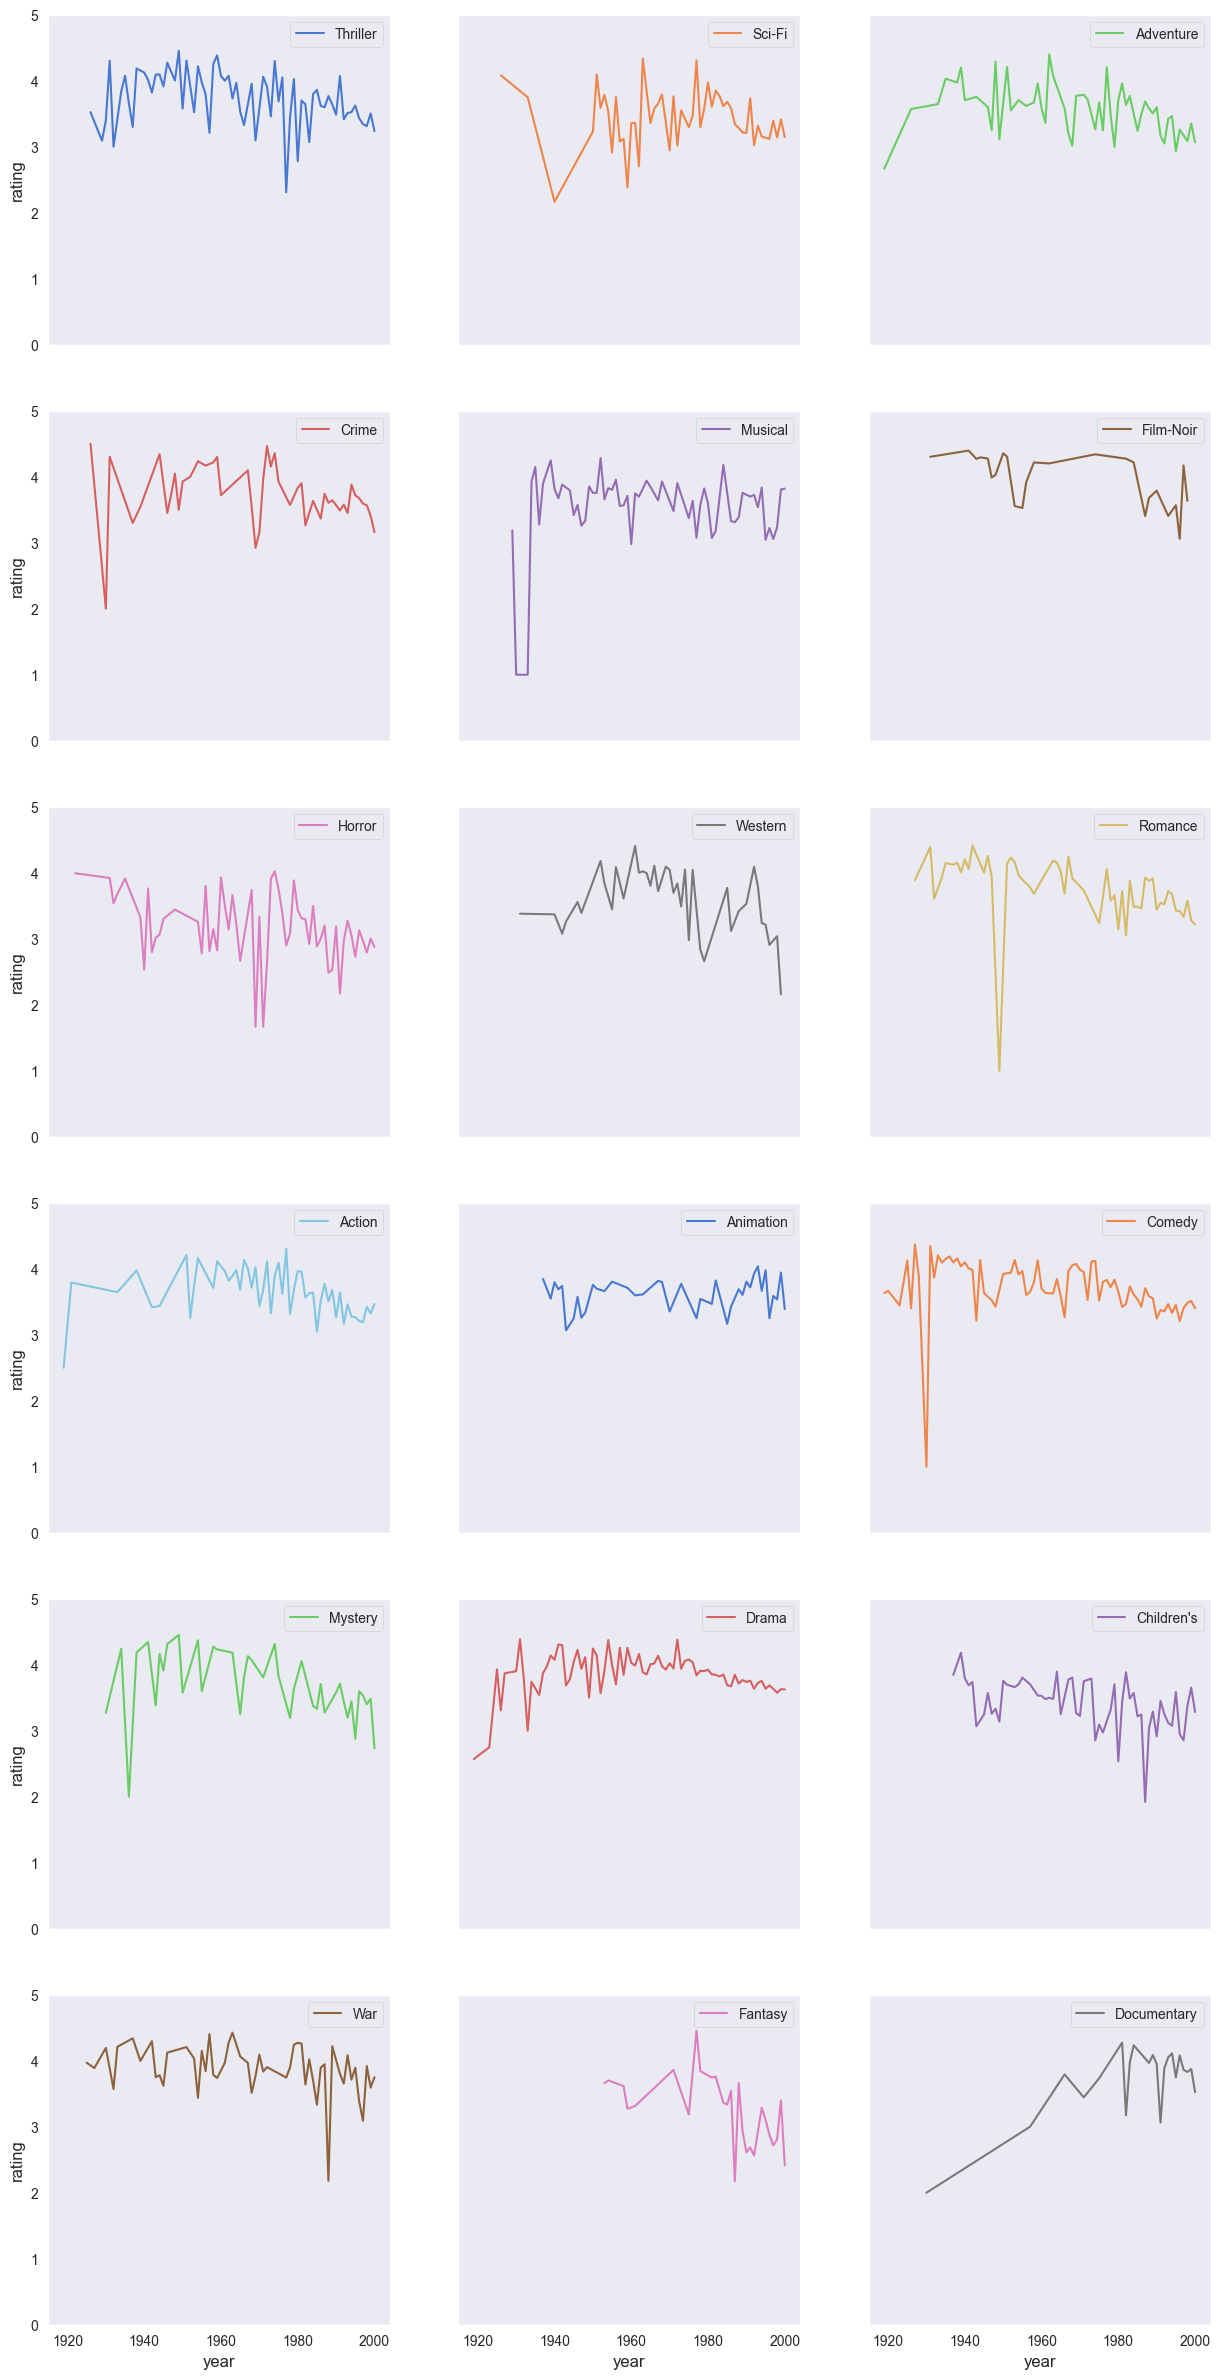

In [17]:
fig, axes = plt.subplots(6, 3, figsize=(15, 30), sharex=True, sharey=True)
plt.ylim(0,5)
colors = sns.color_palette("muted", n_colors=18)
for genre, ax, color in zip(unique_genres, axes.flatten(), colors):
    tmp_ = tmp[tmp[genre] == 1].groupby(['year']).agg({'rating': 'mean'}).reset_index()
    sns.lineplot(data=tmp_, x='year', y='rating', label=genre, ax=ax, color=color)
              

There is no clear trend in the average rating over time.

## Utility Matrix

The utility matrix is a matrix where each row represents a user and each column represents a movie. The values in the matrix are the ratings given by the users to the movies. It is a sparse matrix because most users have not rated most movies.

In [18]:
utility_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
print('Percentage of missing values: {:.2f}%'.format(utility_matrix.isnull().sum().sum() / (utility_matrix.shape[0] * utility_matrix.shape[1]) * 100))
utility_matrix

Percentage of missing values: 95.53%


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Train and Test Sets

We are going to split the utility matrix into train and test sets. At this point we need to fill the missing values because the NMF algorithm cannot handle them. We are going use multiples fillings such as fill with the mean of the column, fill with the mean of the row and fill with a constant value, and then we are going to compare the results.

In [19]:
utility_matrix.mean(axis=1)

user_id
1       4.188679
2       3.713178
3       3.901961
4       4.190476
5       3.146465
          ...   
6036    3.302928
6037    3.717822
6038    3.800000
6039    3.878049
6040    3.577713
Length: 6040, dtype: float64

In [20]:
tmp = utility_matrix.copy()
tmp_ = 
tmp_

SyntaxError: invalid syntax (964461901.py, line 2)

In [21]:
def process_utility_matrix(data, value_to_fill=0, axis=None, random_seed=random_seed, test_size=0.2):
    if value_to_fill == 'mean':
        if axis is None:
            raise ValueError("Please specify the axis for filling with mean value.")
        if axis == 1:
            filled_data = data.apply(lambda row: row.fillna(row.mean()), axis=1)
        elif axis == 0:
            filled_data = data.fillna(data.mean(axis=0), axis=0)
        else:
            raise ValueError("Invalid axis. Please use 0 or 1.")
    elif isinstance(value_to_fill, int) and 0 <= value_to_fill <= 5:
        filled_data = data.fillna(value_to_fill)
    else:
        raise ValueError("Invalid value_to_fill. If 'mean' is selected, specify axis (0 or 1). If a number between 0 and 5 is selected, no axis is needed.")
    
    train, test = train_test_split(filled_data, test_size=test_size, random_state=random_seed)

    return train, test

utility_matrix_train, utility_matrix_test = process_utility_matrix(utility_matrix, value_to_fill=0)
utility_matrix_train

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
299,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
5661,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4932,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3265,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0


## Model

In [22]:
def get_rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten() 
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(np.mean((pred - actual)**2))

In [28]:
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

nmf = NMF(n_components=20, random_state=random_seed, )
nmf.fit(utility_matrix_train)
nmf_train = nmf.transform(utility_matrix_train)
nmf_test = nmf.transform(utility_matrix_test)

In [31]:
reconstructed_test = nmf.inverse_transform(nmf_test)
test_error = get_rmse(reconstructed_test, utility_matrix_test.values)
test_error

2.4617370978627777